# Landfill Detection with YOLO11 

### Environment variables import

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()  # take environment variables from .env.

ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")
VERSION = 2

### Get Dataset from ROBOFLOW

In [2]:
from roboflow import Roboflow

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("personals").project("aerial-dumping-sites-9badf")
dataset = project.version(VERSION).download("coco", location=f"./.local_dataset/v{VERSION}/")

loading Roboflow workspace...
loading Roboflow project...


## Register Dataset

In [3]:
import torchvision
import os
from transformers import YolosImageProcessor


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.feature_extractor(
            images=img, annotations=target, return_tensors="pt"
        )
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension

        target = encoding["labels"][0]  # remove batch dimension

        return pixel_values, target


feature_extractor = YolosImageProcessor.from_pretrained(
    "hustvl/yolos-small", size=512, max_size=864
)

train_dataset = CocoDetection(
    img_folder=(dataset.location + "/train"), feature_extractor=feature_extractor
)
val_dataset = CocoDetection(
    img_folder=(dataset.location + "/valid"),
    feature_extractor=feature_extractor,
    train=False,
)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 2328
Number of validation examples: 240


### Vizualize that our data has loaded correctly - You can hit this cell as many times as you want to vizualize how your training set has loaded


Image n°1283


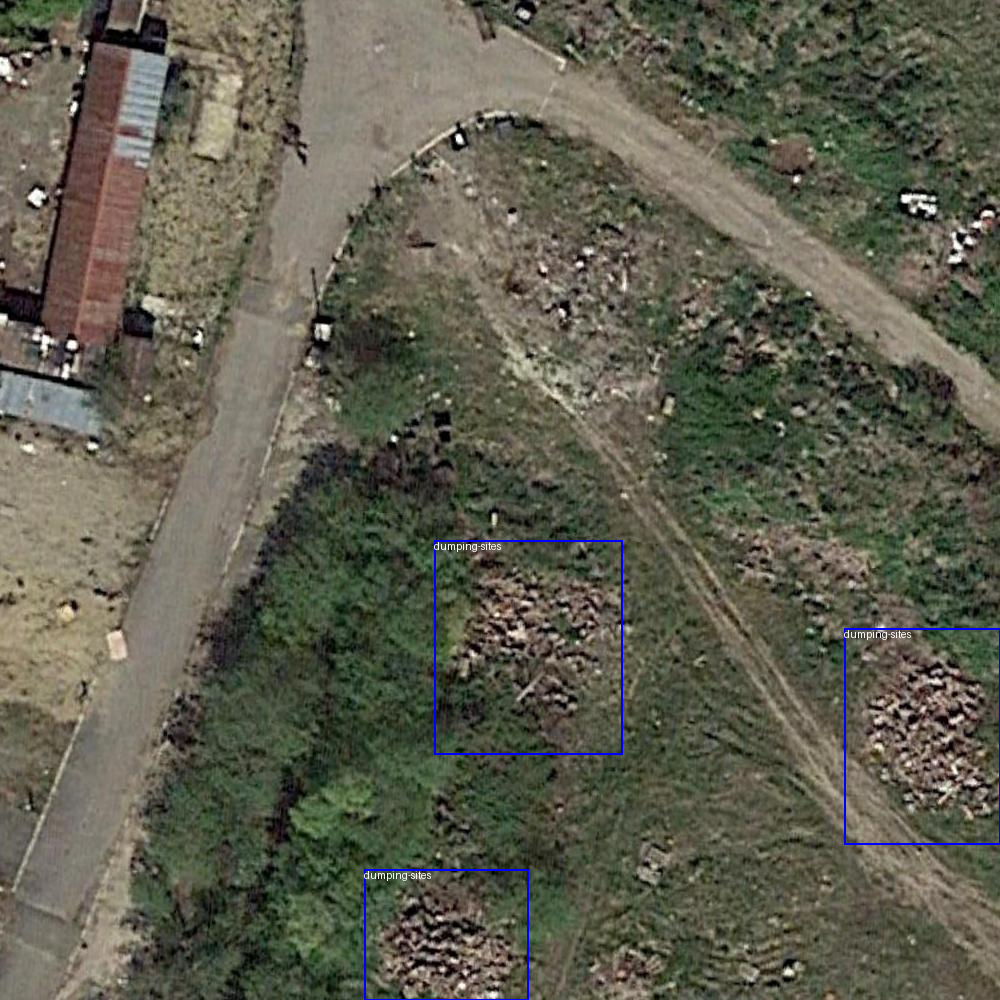

In [4]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print("Image n°{}".format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(dataset.location + "/train", image["file_name"]))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v["name"] for k, v in cats.items()}

for annotation in annotations:
    box = annotation["bbox"]
    class_idx = annotation["category_id"]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="blue", width=2)
    draw.text((x, y), id2label[class_idx], fill="white")

image

# Training

### Setup Data Loader

In [5]:
from torch.utils.data import DataLoader


def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["labels"] = labels
    return batch


train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True
)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
batch = next(iter(train_dataloader))

## Setup YOLO Model

In [6]:
import pytorch_lightning as pl
from transformers import DetrConfig, AutoModelForObjectDetection
import torch


# we wrap our model around pytorch lightning for training
class YoloS(pl.LightningModule):

    def __init__(self, lr, weight_decay):
        super().__init__()
        # replace COCO classification head with custom head
        self.model = AutoModelForObjectDetection.from_pretrained(
            "hustvl/yolos-tiny", num_labels=len(id2label), ignore_mismatched_sizes=True
        )
        # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
        self.lr = lr
        self.weight_decay = weight_decay
        self.save_hyperparameters()  # adding this will save the hyperparameters to W&B too

    def forward(self, pixel_values):
        outputs = self.model(pixel_values=pixel_values)

        return outputs

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log(
            "train/loss", loss
        )  # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace
        for k, v in loss_dict.items():
            self.log(
                "train/" + k, v.item()
            )  # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log(
            "validation/loss", loss
        )  # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace
        for k, v in loss_dict.items():
            self.log(
                "validation/" + k, v.item()
            )  #  logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

## Train the model

In [7]:
!export PYTORCH_ENABLE_MPS_FALLBACK=1

In [8]:
from pytorch_lightning.callbacks import ModelCheckpoint

model = YoloS(lr=2.5e-5, weight_decay=1e-4)

# Keep track of the checkpoint with the lowest validation loss
checkpoint_callback = ModelCheckpoint(monitor="validation/loss", mode="min")

from pytorch_lightning import Trainer

# more epochs leads to a tighter fit of your model to your data.
trainer = Trainer(
    accelerator='auto',
    max_epochs=50,
    gradient_clip_val=0.1,
    accumulate_grad_batches=8,
    log_every_n_steps=5,
    callbacks=[checkpoint_callback],
) 
trainer.fit(model)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([3]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([3, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/satan/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosyst

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/satan/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
The operator 'aten::upsample_bicubic2d.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
/opt/homebrew/Caskroom/miniconda/base/envs/satan/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/opt/homebrew/Caskroom/miniconda/base/envs/satan/lib/python3.12/site-packages/pytorch_lightning/trainer/

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined